In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# write a class for kmeans clusering with nan
from KMeansMissing import kmeans_missing

In [2]:
sacog = pd.read_excel('../data/manipulatedData/sacog_with_new_variables.xlsx')

In [3]:
# Ordered by the mean of portion of online shopping, high to low
cat = ['ChildcareItems', 'Clothing', 'Medication', 'HomeOffice', 'PreparedFood', 'OtherFood', 'PaperCleaning', 'Groceries' ]

In [5]:
# subset is for initialization of centroids
subset = sacog[~sacog[['May-Portion-E'+cat_ for cat_ in cat]].isna().any(axis = 1)]
subset = subset[['May-Portion-E'+cat_ for cat_ in cat]]
# X is for clustering, contain all 327 records, with nan representing 'no shopping'
X = sacog[['May-Portion-E'+cat_ for cat_ in cat]]

In [21]:
K = range(2, 15)
cost = []
sil = []
for k in K:
    km = kmeans_missing(subset.to_numpy(), k)
    km.fit(X, 10000, 1000, init = 'kmeans++')
    cost.append(km.costs)
    sil.append(km.silhouette(X))

/Users/apple/Desktop/UCB/Qual/PhD idea/dataset/online shopping dataset/script/KMeansMissing.py:115: RuntimeWarning: invalid value encountered in double_scalars
  sil_.append((b - a)/max(a,b))
/Users/apple/Desktop/UCB/Qual/PhD idea/dataset/online shopping dataset/script/KMeansMissing.py:73: RuntimeWarning: Mean of empty slice
  centroids[j] = np.nanmean(data[clusters == j], axis = 0)


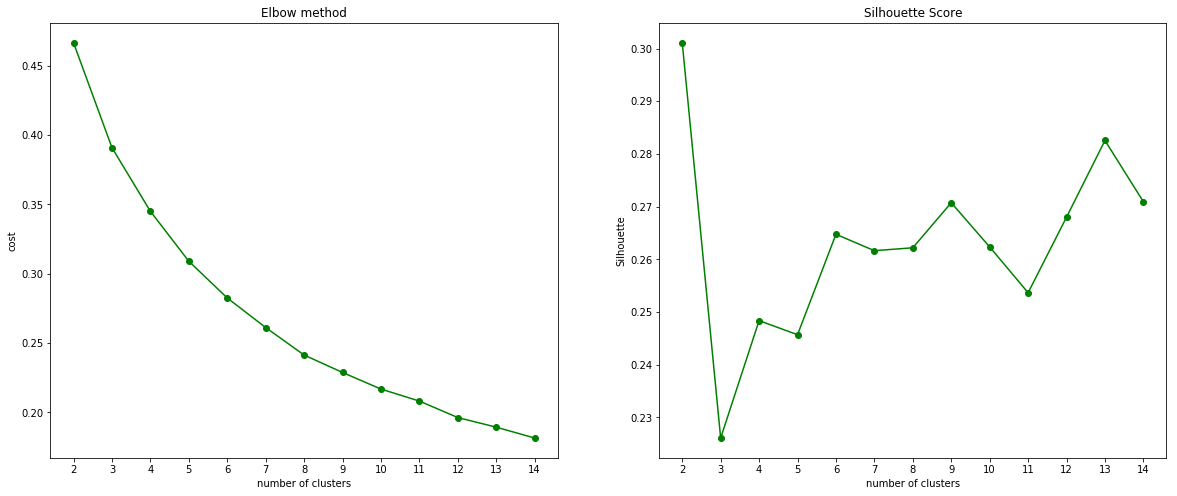

In [22]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
ax[0].plot(K, cost, 'go-')
ax[0].set_xlabel('number of clusters')
ax[0].set_ylabel('cost')
ax[0].set_title('Elbow method')
ax[0].set_xticks(K)

ax[1].plot(K, sil, 'go-')
ax[1].set_xlabel('number of clusters')
ax[1].set_ylabel('Silhouette')
ax[1].set_title('Silhouette Score')
ax[1].set_xticks(K)

### KMeans with NaN? For data with NaN, only calculate the distance between the point and the centroids using available information. Assign it to the closest center. The center value is calculated by taking the average of records without NaN for each attribute.

In [23]:
km6 = kmeans_missing(subset.to_numpy(), 6)
km6.fit(X, 10000, 10000, init = 'kmeans++')

In [9]:
km4 = kmeans_missing(subset.to_numpy(), 4)
km4.fit(X, 10000, 10000, init = 'kmeans++')

In [19]:
km5 = kmeans_missing(subset.to_numpy(), 5)
km5.fit(X, 10000, 10000, init = 'kmeans++')

In [26]:
group = ['EPreparedFood', 'ECommerce Independent', 'Partially ECommerce Dependent', 'ENonFood + Res', 'ENonFood', 'ECommerce Dependent']

In [27]:
label = [group[x] for x in [5,0,4,1,2,3]]

In [29]:
df = pd.DataFrame(km6.centroids, columns=cat)
df['group size'] = np.unique(km6.labels, return_counts = True)[1]
#df = df.reindex([5,0,4,1,2,3])
df.set_index(pd.Index(group), inplace = True)
df.style.background_gradient(subset = cat)

In [3]:
order = pd.Categorical(['no shopping', 'in-store only', 'more in-store', 'same freq', 'more online', 'online only'], ordered = True)
plt.figure(figsize=(20, 20))
for j in range(6):
    plt.subplot(3, 2, j+1)
    df = pd.DataFrame()
    for i in range(8):
        summary = sacog[km6.labels == j]['style1-'+ cat[i]].value_counts(normalize = True).to_frame()
        df = df.join(summary, how='outer')
    df.reindex(order).T.plot(kind = 'bar', stacked = True, ax = plt.gca(), color=tuple(list(sns.diverging_palette(0, 255, sep=1, n=6))))
    plt.xticks(rotation=20)
    plt.title(group[j])
    plt.legend(title='Shopping Channels', bbox_to_anchor=(-.05, 1), loc='upper right')
    if j % 2 == 1:
        plt.gca().get_legend().remove()

    for rect in plt.gca().patches:
    # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()
        # The height of the bar is the data value and can be used as the label
        label_text = f'{height:.2f}'  # f'{height:.2f}' to format decimal values
        # ax.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2

    # plot only when height is greater than specified value
        if height > 0:
            plt.gca().text(label_x, label_y, label_text, ha='center', va='center', fontsize=10)

NameError: name 'pd' is not defined

NameError: name 'df' is not defined

#### Among who shopped, the percentage of people that shopped at least as frequently as in-store shopping

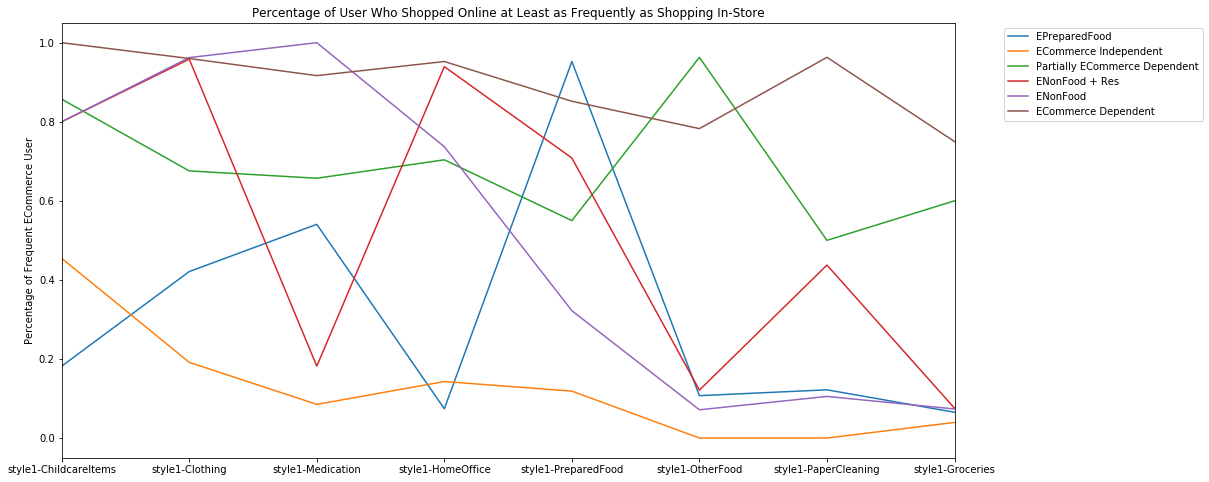

In [31]:
order = pd.Categorical(['no shopping', 'in-store only', 'more in-store', 'same freq', 'more online', 'online only'], ordered = True)
df_ = pd.DataFrame()
for j in range(6):
    df = pd.DataFrame()
    for i in range(8):
        summary = sacog[(km6.labels == j)&(sacog['style1-'+ cat[i]] != 'no shopping')]['style1-'+ cat[i]].value_counts(normalize = True).to_frame()
        df = df.join(summary, how='outer')
    df_[group[j]] = df.loc[['same freq', 'more online', 'online only']].sum(axis=0)
plt.figure(figsize = (16, 8))
df_.plot(kind = 'line', ax = plt.gca())
plt.ylabel('Percentage of Frequent ECommerce User')
plt.title('Percentage of User Who Shopped Online at Least as Frequently as Shopping In-Store')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')

#### ECommerce seems like a complementary of in-store shopping rather than substitution. if a group has a higher portion of online shopping for certain category, it usually has a higher total purchase events than the other group. ECommerce independent group usually has less purchase events than the other groups.

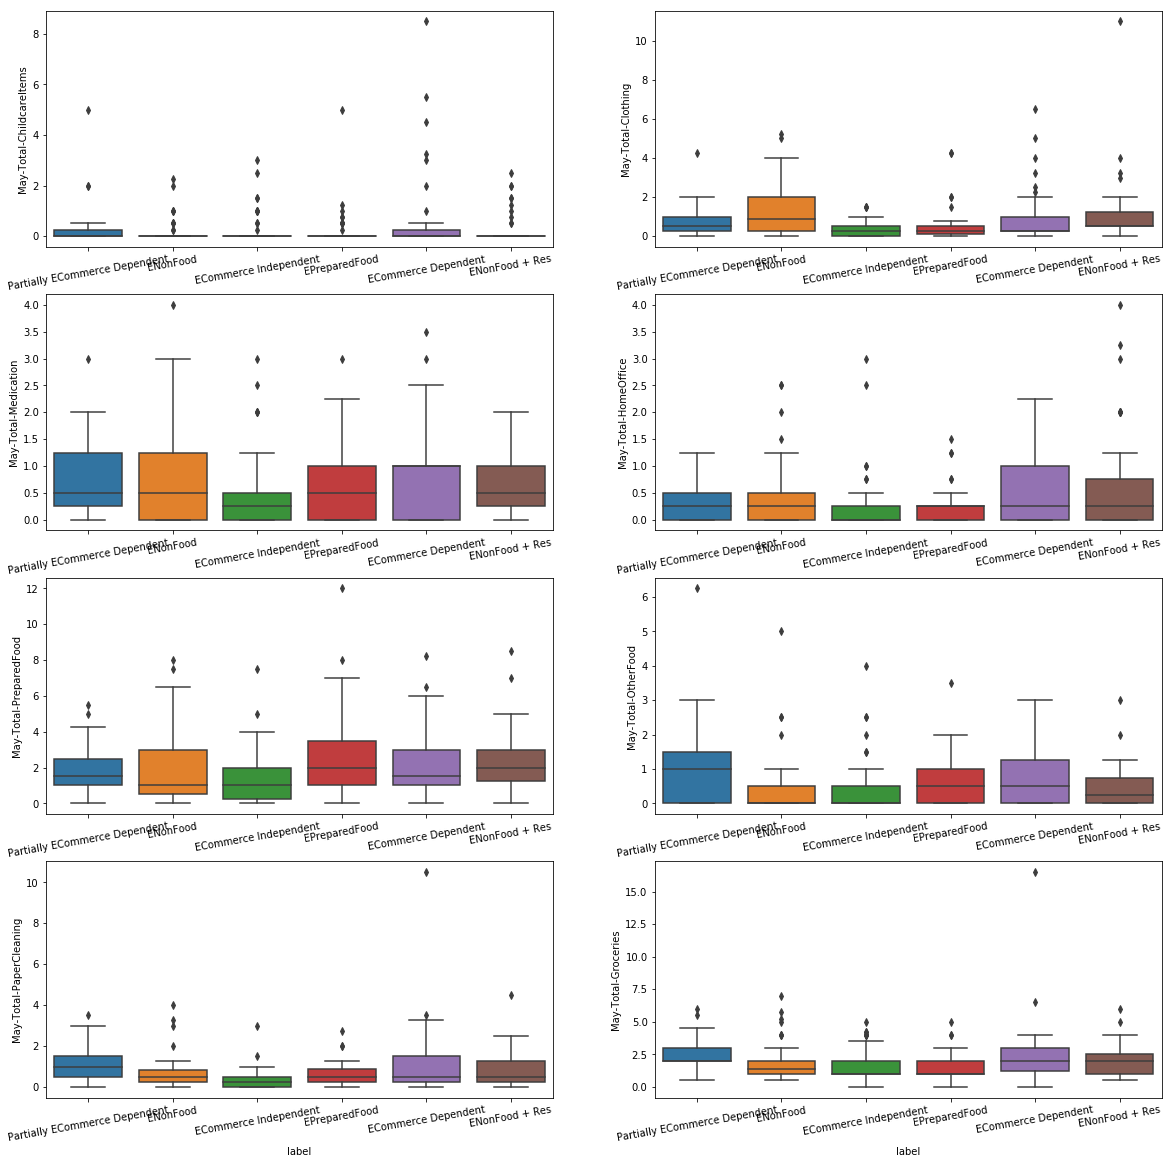

In [32]:
total = sacog[['May-Total-'+cat_ for cat_ in cat]]/4 # Total shopping events per week
total['label'] = [group[int(x)] for x in km6.labels]

plt.figure(figsize = (20, 20))
for i in range(len(cat)): 
    plt.subplot(4, 2, i+1)
    sns.boxplot(x = 'label', y = 'May-Total-'+cat[i], data=total)
    plt.xticks(rotation=10)

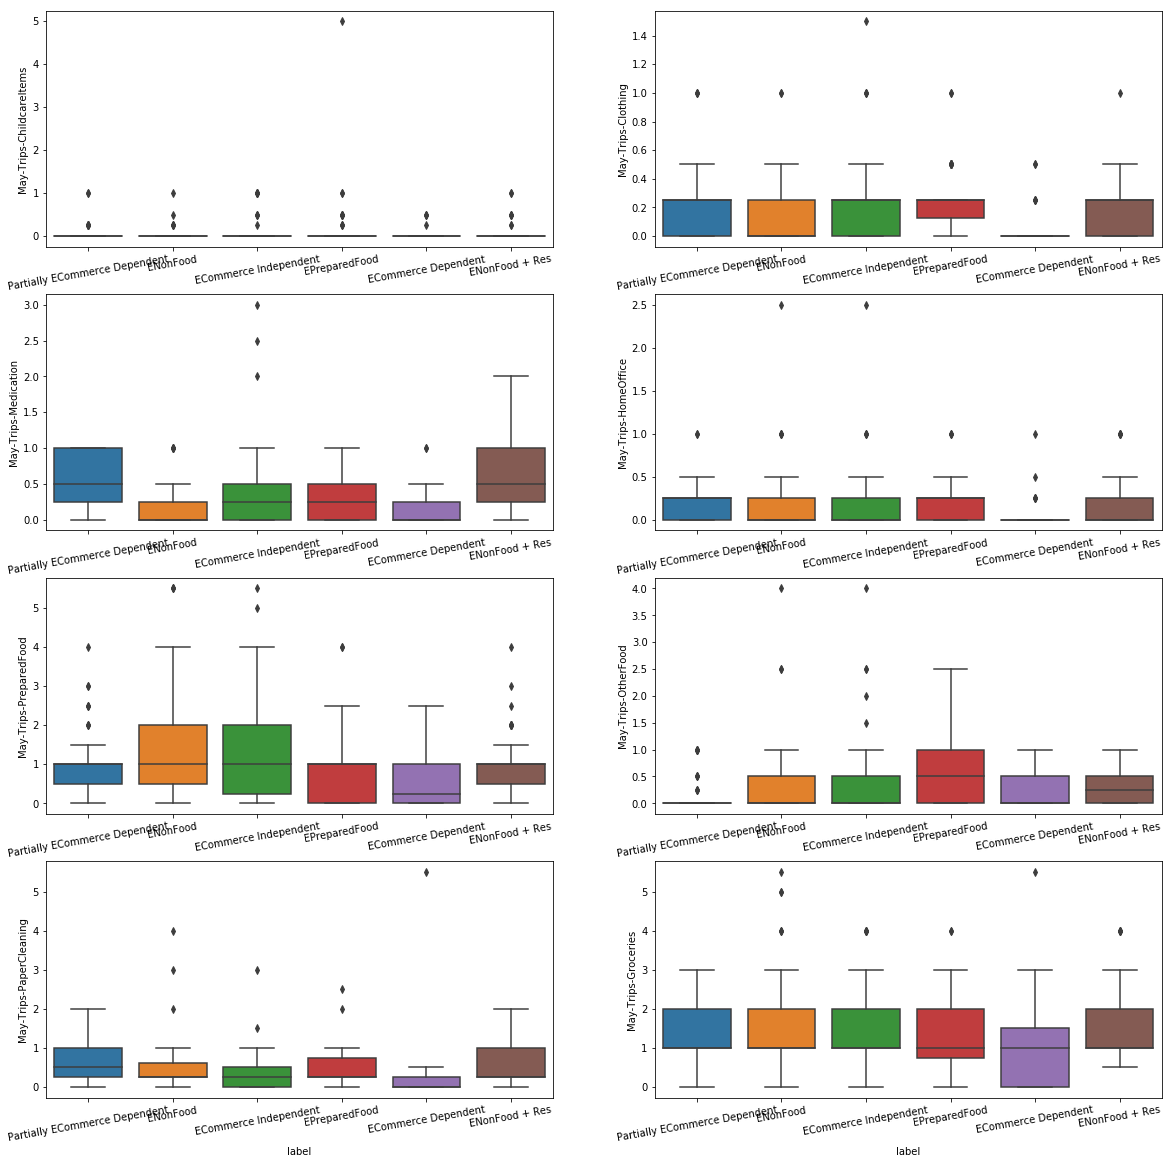

In [36]:
total = sacog[['May-Trips-'+cat_ for cat_ in cat]]/4 # Total shopping trips per week
total['label'] = [group[int(x)] for x in km6.labels]

plt.figure(figsize = (20, 20))
for i in range(len(cat)): 
    plt.subplot(4, 2, i+1)
    sns.boxplot(x = 'label', y = 'May-Trips-'+cat[i], data=total)
    plt.xticks(rotation=10)

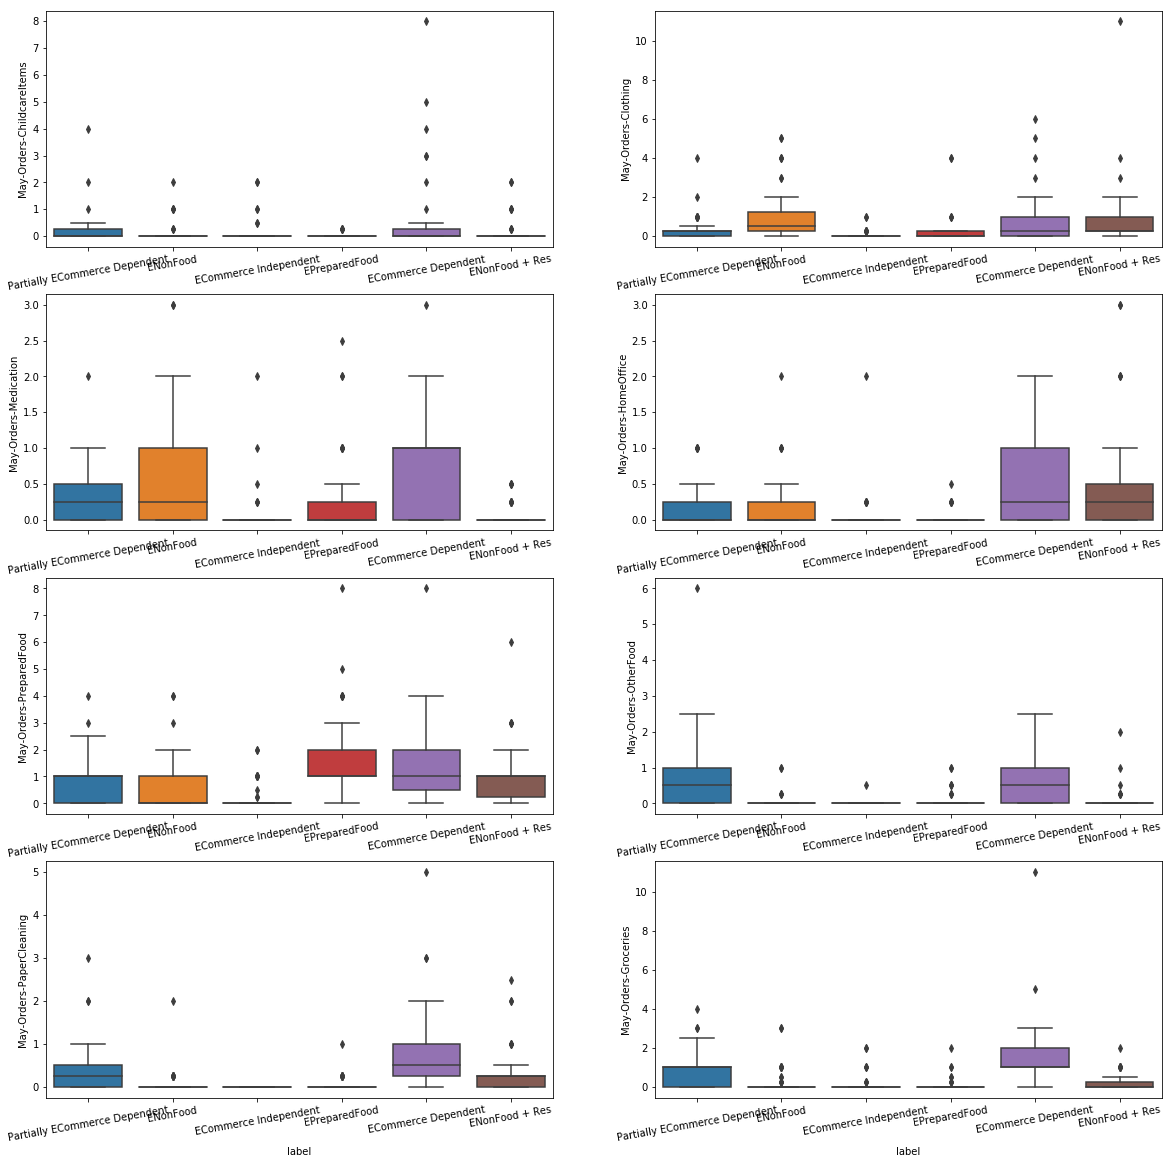

In [37]:
total = sacog[['May-Orders-'+cat_ for cat_ in cat]]/4 # Total online orders per week
total['label'] = [group[int(x)] for x in km6.labels]

plt.figure(figsize = (20, 20))
for i in range(len(cat)): 
    plt.subplot(4, 2, i+1)
    sns.boxplot(x = 'label', y = 'May-Orders-'+cat[i], data=total)
    plt.xticks(rotation=10)

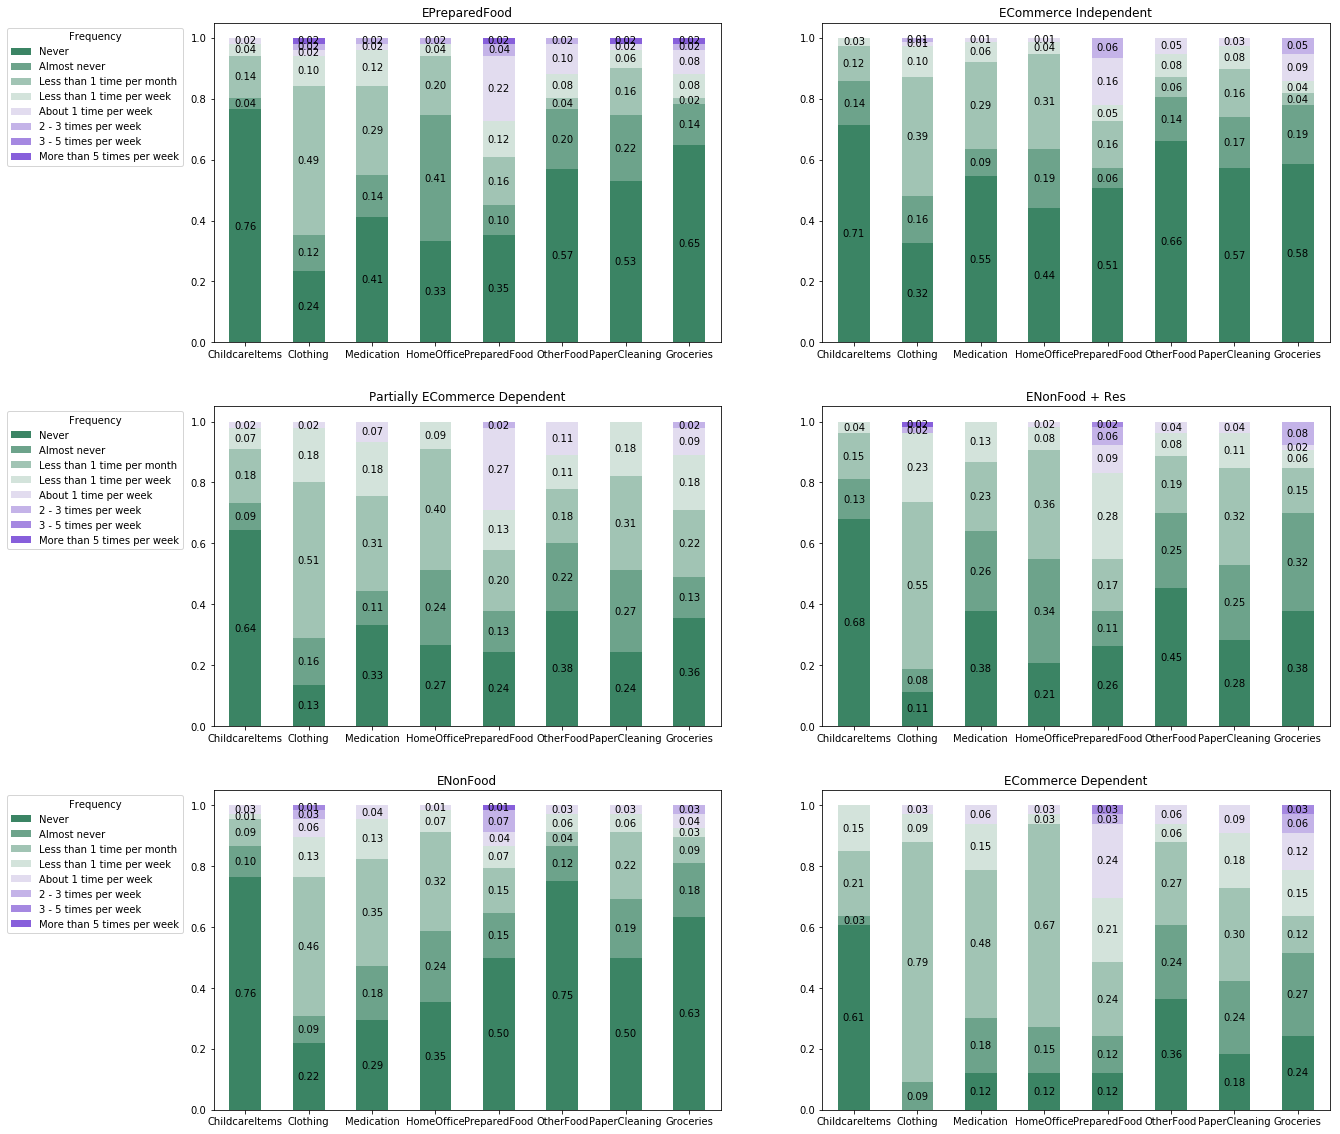

In [38]:
order = pd.Categorical(['Never', 'Almost never','Less than 1 time per month', 'Less than 1 time per week', 'About 1 time per week', '2 - 3 times per week', '3 - 5 times per week', 'More than 5 times per week'], ordered=True)
plt.figure(figsize=(20, 20))
for i in range(6):
    df = pd.DataFrame()
    plt.subplot(3, 2, i+1)
    for cat_ in cat:
        summary = sacog[km6.labels==i]['PastYear-ECommerce-Frequency-'+cat_].value_counts(normalize=True)
        df = df.join(summary, how='outer')
    df.set_axis(cat, axis = 1, inplace = True)
    df.reindex(order).T.plot(kind = 'bar',stacked=True, ax = plt.gca(), color=tuple(list(sns.diverging_palette(150, 275, sep=1, n=8))))
    plt.xticks(rotation=0)
    plt.title(group[i])
    plt.legend(title = 'Frequency', bbox_to_anchor = (-.05, 1), loc = 'upper right')
    if i % 2 == 1:
        plt.gca().legend().remove()
        
    for rect in plt.gca().patches:
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()
        
        label_text = f'{height:.2f}'
        label_x = x + width/2
        label_y = y + height/2
        
        if height > 0:
            plt.gca().text(label_x, label_y, label_text, ha = 'center', va = 'center', fontsize = 10)

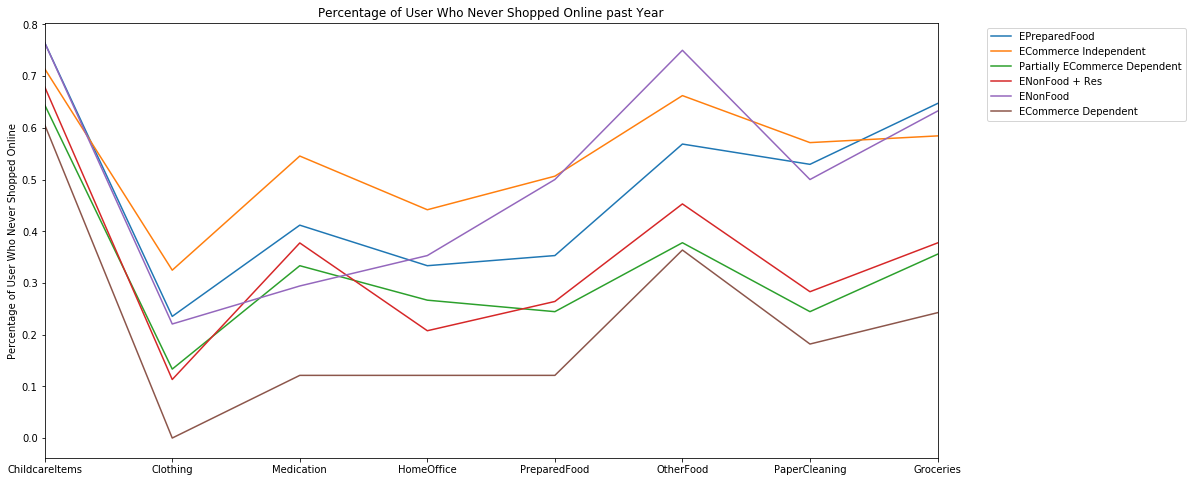

In [39]:
order = pd.Categorical(['Never', 'Almost never','Less than 1 time per month', 'Less than 1 time per week', 'About 1 time per week', '2 - 3 times per week', '3 - 5 times per week', 'More than 5 times per week'], ordered=True)
df_ = pd.DataFrame()
for j in range(6):
    df = pd.DataFrame()
    for i in range(8):
        summary = sacog[km6.labels == j]['PastYear-ECommerce-Frequency-'+cat[i]].value_counts(normalize = True).to_frame()
        df = df.join(summary, how='outer')
    df_[group[j]] = df.loc[['Never']].sum(axis=0)
df_.set_index(pd.Index(cat), inplace = True)
plt.figure(figsize = (16, 8))
df_.plot(kind = 'line', ax = plt.gca())
plt.ylabel('Percentage of User Who Never Shopped Online')
plt.title('Percentage of User Who Never Shopped Online past Year')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')

#### Inertia
Among all the categories, the precentage of people who never conducted online shopping for clothing in the past year is usually the lowest (or second lowest). ECommerce dependent customers usually have experience of online shopping across all the categories while ECommerce Independent Group has relatively higher portion of people who haven't experienced online shopping in the past year. The exposure rate of online shopping is similar for Partially ECommerce Dependent and ENonfood + Res group users. EPreparedFood has made its way through certain group of people. We can see that the percentage of non-experiencer in EPreparedFood group is not among the lowest, however, it has the highest portion of people who ordered restaurant food online as frequent as they shopped in-store during the pandemic. ENonFood is not a fan of online shopping for either food or papercleaning both in the past and during the pandemic.

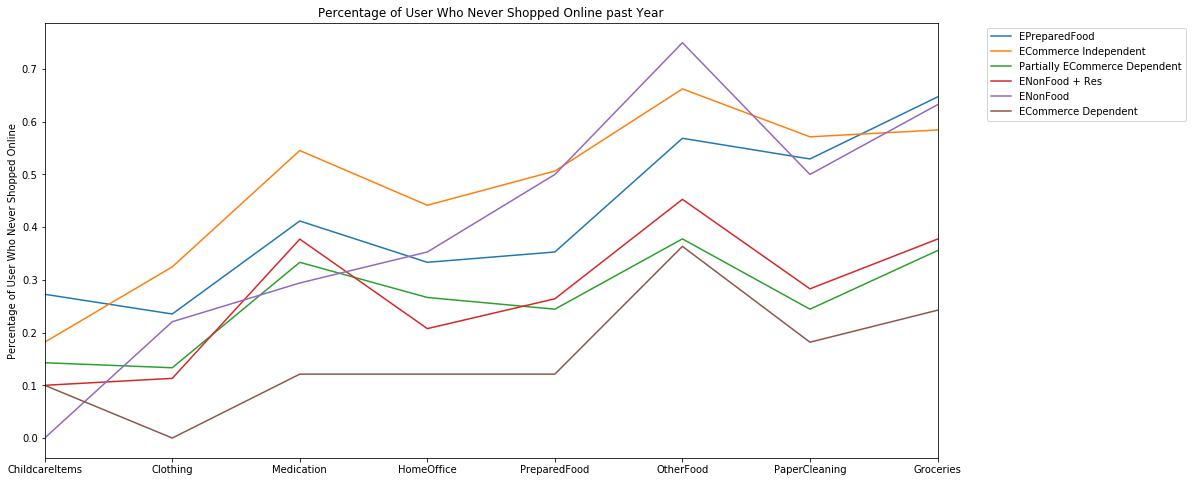

In [40]:
order = pd.Categorical(['Never', 'Almost never','Less than 1 time per month', 'Less than 1 time per week', 'About 1 time per week', '2 - 3 times per week', '3 - 5 times per week', 'More than 5 times per week'], ordered=True)
df_ = pd.DataFrame()
for j in range(6):
    df = pd.DataFrame()
    # For childcareItems, infer whether they have the needs by looking at whether they conduct shopping or not in 2020
    summary = sacog[(km6.labels ==j) & (sacog['style1-ChildcareItems']!='no shopping')]['PastYear-ECommerce-Frequency-ChildcareItems'].value_counts(normalize = True).to_frame()
    df = df.join(summary, how='outer')
    
    for i in range(1,8):
        summary = sacog[km6.labels == j]['PastYear-ECommerce-Frequency-'+cat[i]].value_counts(normalize = True).to_frame()
        df = df.join(summary, how='outer') 
    df_[group[j]] = df.loc[['Never']].sum(axis=0)
df_.set_index(pd.Index(cat), inplace = True)
plt.figure(figsize = (16, 8))
df_.plot(kind = 'line', ax = plt.gca())
plt.ylabel('Percentage of User Who Never Shopped Online')
plt.title('Percentage of User Who Never Shopped Online past Year')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')

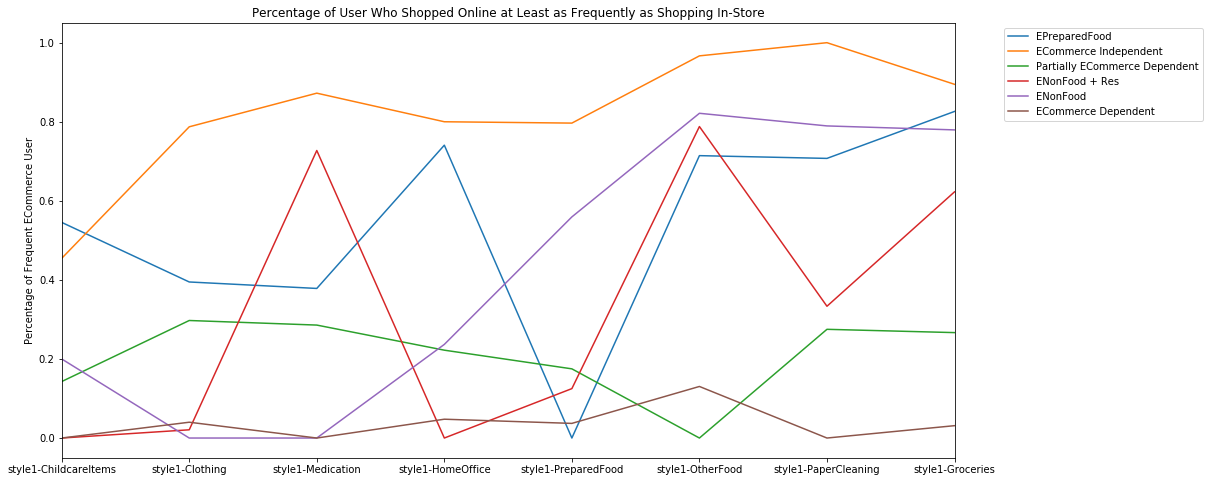

In [42]:
order = pd.Categorical(['no shopping', 'in-store only', 'more in-store', 'same freq', 'more online', 'online only'], ordered = True)
df_ = pd.DataFrame()
for j in range(6):
    df = pd.DataFrame()
    for i in range(8):
        summary = sacog[(km6.labels == j)&(sacog['style1-'+ cat[i]] != 'no shopping')]['style1-'+ cat[i]].value_counts(normalize = True).to_frame()
        df = df.join(summary, how='outer')
    df_[group[j]] = df.loc[['in-store only']].sum(axis=0)
plt.figure(figsize = (16, 8))
df_.plot(kind = 'line', ax = plt.gca())
plt.ylabel('Percentage of Frequent ECommerce User')
plt.title('Percentage of User Who Shopped Online at Least as Frequently as Shopping In-Store')
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')

In [79]:
X.groupby(km6.labels).mean()

May-Portion-EChildcareItems  May-Portion-EClothing  \
0.0                     0.676923               0.460224   
1.0                     0.638889               0.784426   
2.0                     0.151515               0.234477   
3.0                     0.406061               0.117021   
4.0                     0.578788               0.669825   
5.0                     0.966223               0.933402   

     May-Portion-EMedication  May-Portion-EHomeOffice  \
0.0                 0.344444                 0.454321   
1.0                 0.773641                 0.507018   
2.0                 0.459365                 0.048611   
3.0                 0.043262                 0.104762   
4.0                 0.109028                 0.696474   
5.0                 0.860251                 0.888360   

     May-Portion-EPreparedFood  May-Portion-EOtherFood  \
0.0                   0.425039                0.818272   
1.0                   0.202975                0.066667   
2.0                   0.657329                0.135429   
3.0                   0.088309                0.011111   
4.0                   0.481203                0.080556   
5.0                   0.696193                0.702899   

     May-Portion-EPaperCleaning  May-Portion-EGroceries  
0.0                    0.372849                0.393960  
1.0                    0.079127                0.079456  
2.0                    0.114297                0.072980  
3.0                    0.000000                0.030307  
4.0                    0.321764                0.101544  
5.0                    0.852707                0.632311

In [43]:
program = ['AmazonPrime', 'TargetCircle','Shoprunner', 'RestaurantDelivery', 'GroceryDelivery','Other']
membership = pd.DataFrame()
for prog in program:
    summary = sacog.groupby(km6.labels)['Rewards-Member-'+prog].mean().to_frame()
    membership = membership.join(summary, how = 'outer')
    
membership.set_axis(group, inplace=True)
membership.style.background_gradient()

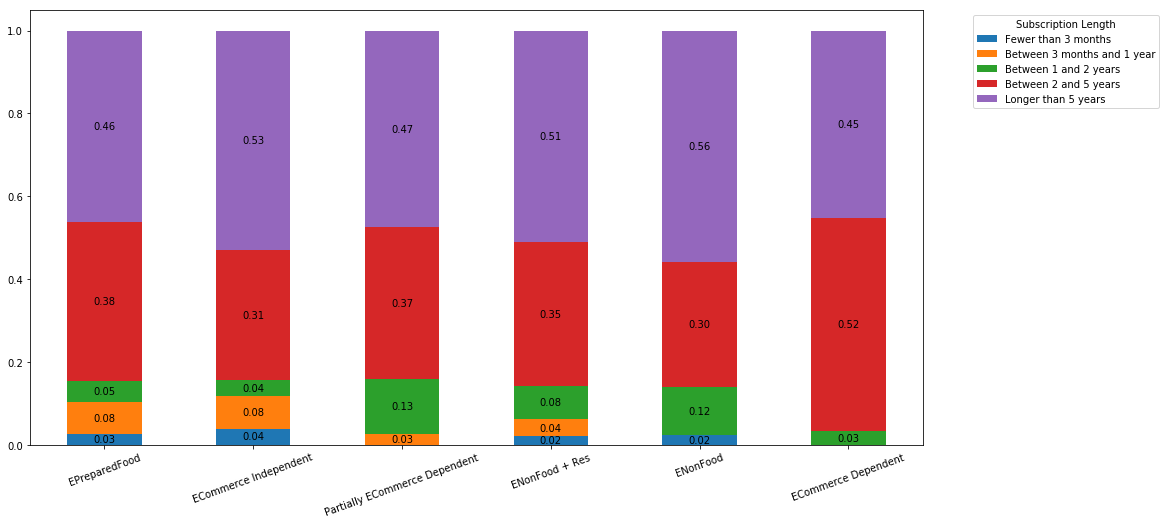

In [44]:
# ECommerce dependent group has the largest portion of people who subscribe prime membership for more than 5 years
df = pd.DataFrame()
order = pd.Categorical(['Fewer than 3 months', 'Between 3 months and 1 year', 'Between 1 and 2 years', 'Between 2 and 5 years', 'Longer than 5 years'], ordered = True)
for j in range(6):
    summary = sacog[(km6.labels == j) & (~sacog['Rewards-Length-AmazonPrime'].isin(['No Response']))]['Rewards-Length-AmazonPrime'].value_counts(normalize = True).to_frame().rename(columns = {'Rewards-Length-AmazonPrime': group[j]})
    df = df.join(summary, how = 'outer')
#subLen.index.set_levels(group, level=0, inplace=True)
#subLen.plot(kind = 'bar', stacked = True)
df.reindex(order).T.plot(kind = 'bar', stacked = True, figsize = (16, 8))
plt.xticks(rotation = 20)
plt.legend(title='Subscription Length', bbox_to_anchor=(1.05, 1), loc='upper left')

for rect in plt.gca().patches:
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    label_text = f'{height:.2f}'
    label_x = x + width/2
    label_y = y + height/2

    if height > 0:
        plt.gca().text(label_x, label_y, label_text, ha = 'center', va = 'center', fontsize = 10)

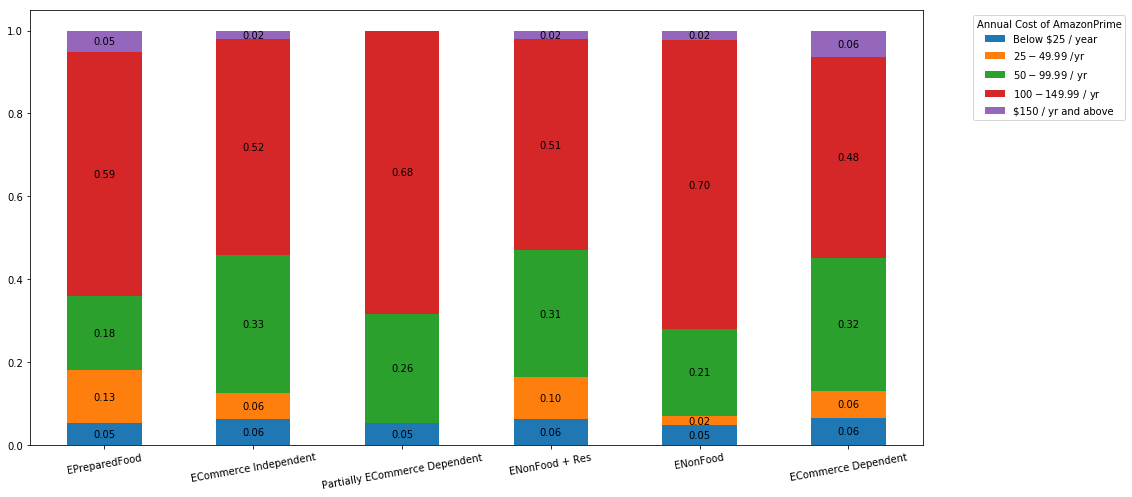

In [45]:
df = sacog.groupby(km6.labels)['Rewards-AnnualCost-AmazonPrime'].value_counts().unstack()
col = df.iloc[:,:5].columns.tolist() # remove no response
col = [col[4],col[2],col[3],col[0],col[1]]
(df[col].T/df[col].sum(axis=1)).rename(columns = {i: group[i] for i in range(6)}).T.plot(kind='bar', stacked = True, figsize = (16, 8))
plt.xticks(rotation = 10)
plt.legend(title = 'Annual Cost of AmazonPrime', bbox_to_anchor = (1.05, 1), loc = 'upper left')

for rect in plt.gca().patches:
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    label_text = f'{height:.2f}'
    label_x = x + width/2
    label_y = y + height/2

    if height > 0:
        plt.gca().text(label_x, label_y, label_text, ha = 'center', va = 'center', fontsize = 10)

In [46]:
subscription = ['Food','Clothing', 'PersonalCare', 'HouseholdItems']
membership = pd.DataFrame()
for prog in subscription:
    summary = sacog.groupby(km6.labels)['Subscription-Member-' + prog].mean().to_frame()
    membership = membership.join(summary, how = 'outer')
    
#membership.set_axis(group, inplace=True)
membership.set_index(pd.Index(group)).style.background_gradient()

In [47]:
sacog[sacog != -9998].groupby(km6.labels)[[
 'DoInStage23-ContactlessDoor',
 'DoInStage23-CurbsidePickup',
 'DoInStage23-InStorePickup',
 'DoInStage23-LockerPickup',
 'DoInStage23-DroneDelivery',
 'DoInStage23-VisitRetail',
 'DoInStage23-VisitRestaurant',
 'DoInStage23-VisitBar',
'DoInStage23-BundlingOnlineGroceries',
 'DoInStage23-CrowdSourcedDelivery',
 'DoInStage23-ContactlessCurbside',
'DoInStage23-ContactlessDriverless']].mean().set_index(pd.Index(group)).style.background_gradient()

EOtherFood user thought both in-person food & nonfood is chore while ECommerce independent user saw both in-store grocery & retail shopping as an excuse to get out; what's more, they enjoy browsing without buying.

In [49]:
sacog[sacog!=-9998][['Behavior-OnlyList',
 'Behavior-NotMindGroceriesOnline',
 'Behavior-NotMindRestaurantOnline',
 'Behavior-InPersonIsChore',
 'Behavior-GroceryExcuseToGetOut',
 'Behavior-PickupExcuseToGetOut']].groupby(km6.labels).mean().set_index(pd.Index(group)).style.background_gradient()


In [50]:
sacog[sacog!=-9998][[
 'ECommerce-Food-EnvironmentallyFriendly',
 'ECommerce-Food-SupportLocal',
 'ECommerce-Food-SavesTime',
 'ECommerce-Food-SavesMoney',
 'ECommerce-Food-HardToKnowExactly',
 'ECommerce-Food-WorryAboutTheft',
 'ECommerce-Food-AvoidCarrying',
 'ECommerce-Food-InstantIsCool']].groupby(km6.labels).mean().set_index(pd.Index(group)).style.background_gradient()


#### ECommerce Independent group is the most likely to enjoy browsing without buying. [Maybe look into their income?]

In [51]:
sacog[sacog!=-9998][['NonFood-OnlineRelaxing',
 'NonFood-EnjoyOnlineClothing',
 'NonFood-EnjoyOnlineElectronice',
 'NonFood-SearchForBestDeals',
 'NonFood-EnjoyBrowsingWOBuying',
 'NonFood-InPersonClothingChore',
 'NonFood-RetailExcuseToGetOut'
 ]].groupby(km6.labels).mean().set_index(pd.Index(group)).style.background_gradient()

In [52]:
sacog[sacog!=-9998][[
 'ECommerce-NonFood-EnvironmentallyFriendly',
 'ECommerce-NonFood-SupportLocal',
 'ECommerce-NonFood-SavesTime',
 'ECommerce-NonFood-SavesMoney',
 'ECommerce-NonFood-HardToKnowExactly',
 'ECommerce-NonFood-WorryAboutTheft',
 'ECommerce-NonFood-CloseAttnToReviews',
 'ECommerce-NonFood-ComparingEasy',
 'ECommerce-NonFood-InstantIsCool']].groupby(km6.labels).mean().set_index(pd.Index(group)).style.background_gradient()

ECommerce dependent person more cautious?

In [53]:
sacog[sacog!=-9998][[
 'COVID-PPEReducesContraction',
 'COVID-PPEReducesTransmission',
 'COVID-AbleSocialDistance']].groupby(km6.labels).mean().set_index(pd.Index(group)).style.background_gradient()

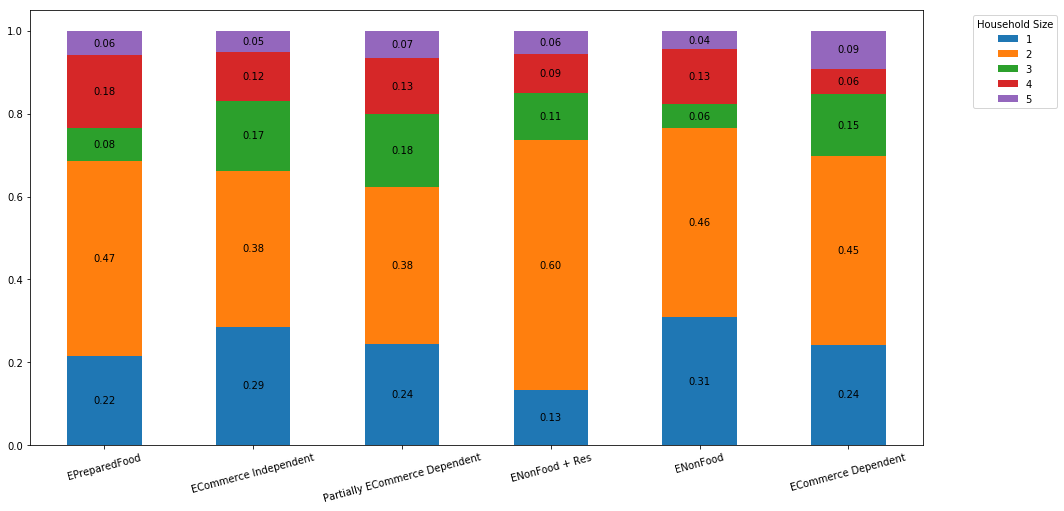

In [54]:
dict_ = dict(zip(range(6), group))
df = pd.DataFrame()
for i in range(6):
    summary = sacog[km6.labels == i]['NumberInHousehold'].value_counts(normalize=True).sort_index().to_frame().rename(columns = {'NumberInHousehold': dict_[i]})
    df = df.join(summary, how = 'outer')
df.T.plot(kind='bar', stacked=True, figsize = (16, 8))
plt.xticks(rotation = 15)
plt.legend(title = 'Household Size', bbox_to_anchor = (1.05, 1), loc='upper left')

for rect in plt.gca().patches:
    # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()
        # The height of the bar is the data value and can be used as the label
        label_text = f'{height:.2f}'  # f'{height:.2f}' to format decimal values
        # ax.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2

    # plot only when height is greater than specified value
        if height > 0:
            plt.gca().text(label_x, label_y, label_text, ha='center', va='center', fontsize=10)

#### Past Year 

In [55]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kmodes.kmodes import KModes
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.features import Rank2D

In [106]:
def choose_k(X, max_k):
    inertia = []
    silhouette_score_ = []
    X = X.fillna(0)
    K = range(2, max_k)
    for k in K:
        km = KMeans(n_clusters = k, n_init = 200, max_iter = 1000, init = 'k-means++')
        km.fit_transform(X)
        inertia.append(km.inertia_)
        silhouette_score_.append(silhouette_score(X, km.labels_))
    fig, ax = plt.subplots(1,2,figsize = (16, 6))
    ax[0].plot(K, inertia, 'go-')
    ax[0].set_xlabel('K')
    ax[0].set_ylabel('Inertia')
    ax[0].set_title('Elbow method for optimal K')
    ax[0].set_xticks(K)
    
    ax[1].plot(K, silhouette_score_, 'bx-')
    ax[1].set_xlabel('K')
    ax[1].set_ylabel('silhouette score')
    ax[1].set_title('Silhouette')
    ax[1].set_xticks(K)

In [104]:
def optimal_k(X, k):
    km = KMeans(n_clusters = k, n_init = 200, max_iter = 1000, init = 'k-means++', random_state=123)
    km.fit_transform(X.fillna(0))
    plt.figure(figsize = (16,5))
    plt.plot(X.columns, km.cluster_centers_.T)
    plt.xticks(rotation=45)
    display(np.unique(km.labels_, return_counts = True))
    return km

In [105]:
X = sacog[['PastYear-Orders-'+cat_ for cat_ in cat]]/4
X.describe()

PastYear-Orders-ChildcareItems  PastYear-Orders-Clothing  \
count                      327.000000                327.000000   
mean                         0.069572                  0.299694   
std                          0.165968                  0.546545   
min                          0.000000                  0.000000   
25%                          0.000000                  0.000000   
50%                          0.000000                  0.250000   
75%                          0.000000                  0.250000   
max                          1.000000                  5.000000   

       PastYear-Orders-Medication  PastYear-Orders-HomeOffice  \
count                  327.000000                  327.000000   
mean                     0.178135                    0.136850   
std                      0.261609                    0.221978   
min                      0.000000                    0.000000   
25%                      0.000000                    0.000000   
50%                      0.000000                    0.000000   
75%                      0.250000                    0.250000   
max                      2.500000                    2.500000   

       PastYear-Orders-PreparedFood  PastYear-Orders-OtherFood  \
count                    327.000000                 327.000000   
mean                       0.449541                   0.135321   
std                        0.758222                   0.297353   
min                        0.000000                   0.000000   
25%                        0.000000                   0.000000   
50%                        0.250000                   0.000000   
75%                        0.500000                   0.250000   
max                        5.000000                   2.500000   

       PastYear-Orders-PaperCleaning  PastYear-Orders-Groceries  
count                     327.000000                 327.000000  
mean                        0.154434                   0.267584  
std                         0.351164                   0.646691  
min                         0.000000                   0.000000  
25%                         0.000000                   0.000000  
50%                         0.000000                   0.000000  
75%                         0.250000                   0.250000  
max                         5.000000                   5.000000

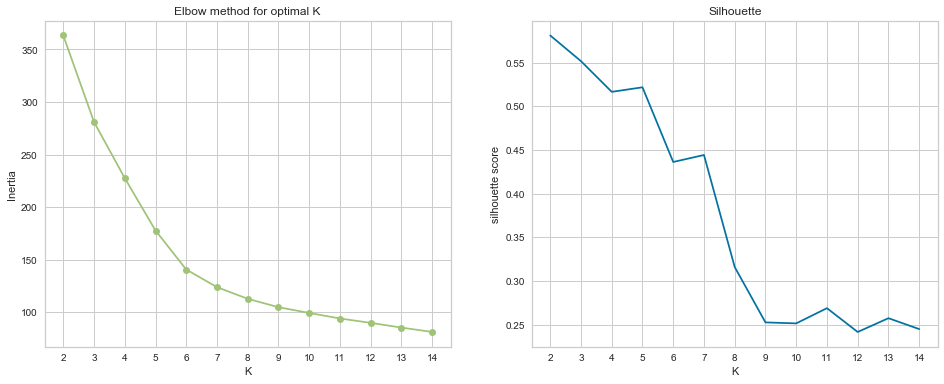

In [107]:
choose_k(X, 15)

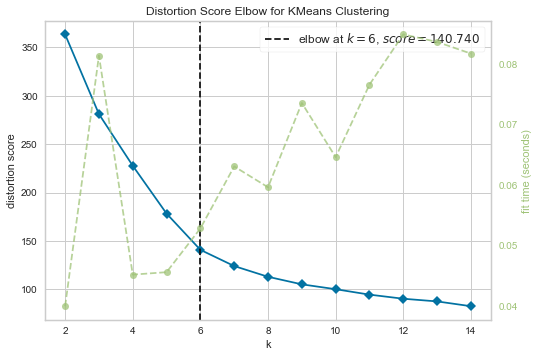

In [108]:
visualize = KElbowVisualizer(KMeans(), k = (2, 15))
visualize.fit(X)
visualize.show()

(array([0, 1, 2, 3, 4], dtype=int32), array([ 45,  20, 255,   1,   6]))

KMeans(max_iter=1000, n_clusters=5, n_init=200, random_state=123)

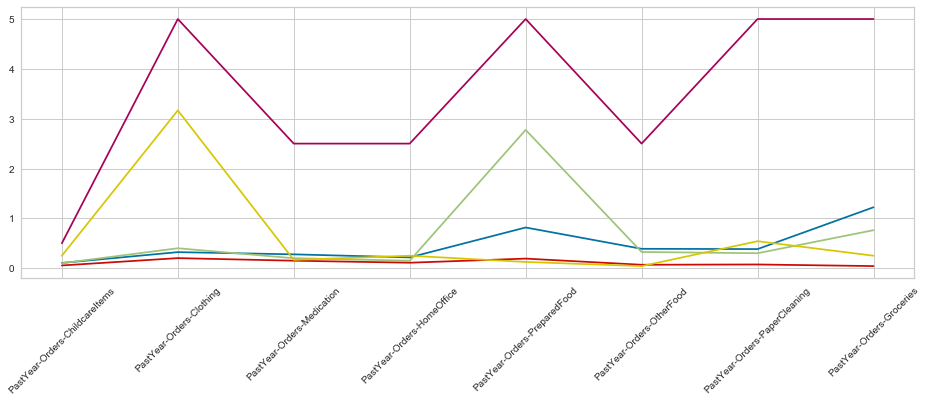

In [110]:
optimal_k(X, 5)

In [62]:
X = sacog[['PastYear_Freq_E'+cat_ for cat_ in cat]]

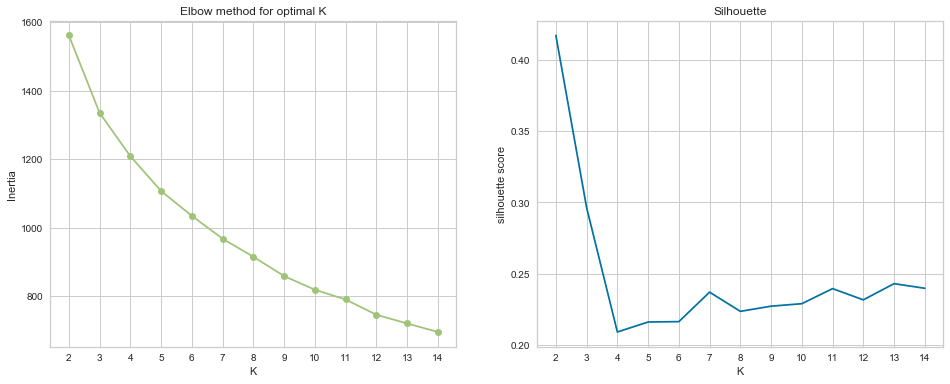

In [63]:
choose_k(X, 15)

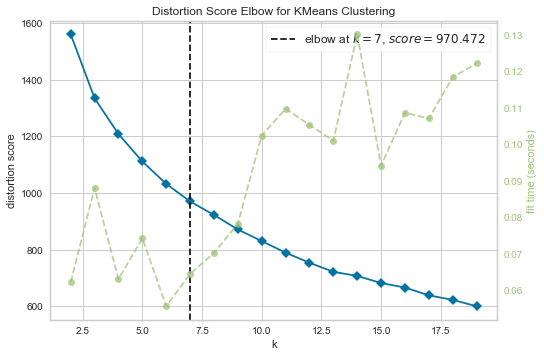

In [69]:
visualize = KElbowVisualizer(KMeans(), k = (2, 20))
visualize.fit(X)
visualize.show()

(array([0, 1, 2, 3, 4, 5], dtype=int32), array([110,  59,  23,  13,  92,  30]))

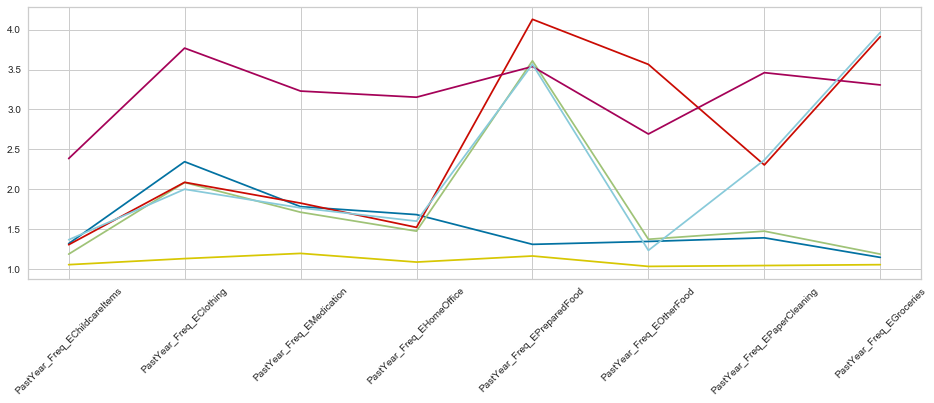

In [91]:
km = optimal_k(X, 6)

In [92]:
df = pd.DataFrame(km.cluster_centers_, columns = cat)
df['Group size'] = np.unique(km.labels_, return_counts = True)[1]
df.style.background_gradient(subset = cat)

In [95]:
pastGroup = ['EClothing', 'EPreparedFood', 'EFood + PaperCleaning', 'ECommerce dependent', 'ECommerce Independent', 'EPrep + EGro + PaperCleaning']

In [96]:
pd.crosstab(np.array([pastGroup[int(i)] for i in km.labels_]), np.array([group[int(i)] for i in km6.labels]), margins = True)

col_0                         ECommerce Dependent  ECommerce Independent  \
row_0                                                                      
EClothing                                      10                     21   
ECommerce Independent                           2                     35   
ECommerce dependent                             3                      2   
EFood + PaperCleaning                           1                      7   
EPrep + EGro + PaperCleaning                    8                      5   
EPreparedFood                                   9                      7   
All                                            33                     77   

col_0                         ENonFood  ENonFood + Res  EPreparedFood  \
row_0                                                                   
EClothing                           29              20             16   
ECommerce Independent               22               9             15   
ECommerce dependent                  1               2              2   
EFood + PaperCleaning                2               4              4   
EPrep + EGro + PaperCleaning         4               3              4   
EPreparedFood                       10              15             10   
All                                 68              53             51   

col_0                         Partially ECommerce Dependent  All  
row_0                                                             
EClothing                                                14  110  
ECommerce Independent                                     9   92  
ECommerce dependent                                       3   13  
EFood + PaperCleaning                                     5   23  
EPrep + EGro + PaperCleaning                              6   30  
EPreparedFood                                             8   59  
All                                                      45  327

In [98]:
pd.DataFrame([np.array([pastGroup[int(i)] for i in km.labels_]),np.array([group[int(i)] for i in km6.labels])]).T.groupby(0)[1].value_counts().sort_index()

0                             1                            
EClothing                     ECommerce Dependent              10
                              ECommerce Independent            21
                              ENonFood                         29
                              ENonFood + Res                   20
                              EPreparedFood                    16
                              Partially ECommerce Dependent    14
ECommerce Independent         ECommerce Dependent               2
                              ECommerce Independent            35
                              ENonFood                         22
                              ENonFood + Res                    9
                              EPreparedFood                    15
                              Partially ECommerce Dependent     9
ECommerce dependent           ECommerce Dependent               3
                              ECommerce Independent             2
                

In [103]:
import plotly.graph_objects as go

fig = go.Figure(data = [go.Sankey(
                        node = dict(
                        pad = 10,
                        thickness = 20,
                        label = ['EClothing', 'ECommerce Independent', 'ECommerce dependent', 'EFood + PaperCleaning', 'EPrep + EGro + PaperCleaning', 'EPreparedFood',
                                 'ECommerce Dependent', 'ECommerce Independent', 'ENonFood', 'ENonFood + Res', 'EPreparedfood', 'Partially ECommerce Dependent']
                        ),
                        link = dict(
                            source = [0]*6 + [1]*6 + [2]*6 + [3]*6 + [4]*6 + [5]*6 ,
                            target = [6,7,8,9,10,11]*6,
                            value = list(pd.DataFrame([np.array([pastGroup[int(i)] for i in km.labels_]),np.array([group[int(i)] for i in km6.labels])]).T.groupby(0)[1].value_counts().sort_index().values)
                        ))]
               )

fig.update_layout(title_text = 'Dynamic of Shopping Style')
fig.show()


In [72]:
km = kmeans_missing(X.to_numpy(), 6)
km.fit(X, 10000, 10000, 'kmeans++')

In [73]:
df = pd.DataFrame(km.centroids, columns = cat)
df['group size'] = np.unique(km.labels, return_counts = True)[1]
df.style.background_gradient(subset=cat)

In [77]:
pastGroup = ['EClothing',  'EFood & PaperCleaning', 'ECommerce Independent', 'ECommerce Dependent', 'EPre & Gro & Paper', 'EPreparedFood']

In [148]:
#pastGroup = ['EClothing', 'EPreparedFood', 'EFood & PaperCleaning', 'ECommerce Dependent', 'ECommerce Independent', 'ERes & Gro & PaperCleaning']

In [78]:
pd.crosstab(np.array([pastGroup[int(i)] for i in km.labels]), np.array([group[int(i)] for i in km6.labels]), margins = True)

col_0                  ECommerce Dependent  ECommerce Independent  ENonFood  \
row_0                                                                         
EClothing                               10                     21        29   
ECommerce Dependent                      0                      0         1   
ECommerce Independent                    2                     35        22   
EFood & PaperCleaning                    3                      9         2   
EPre & Gro & Paper                       9                      5         4   
EPreparedFood                            9                      7        10   
All                                     33                     77        68   

col_0                  ENonFood + Res  EPreparedFood  \
row_0                                                  
EClothing                          20             16   
ECommerce Dependent                 1              2   
ECommerce Independent               9             15   
EFood & PaperCleaning               4              4   
EPre & Gro & Paper                  3              2   
EPreparedFood                      16             12   
All                                53             51   

col_0                  Partially ECommerce Dependent  All  
row_0                                                      
EClothing                                         15  111  
ECommerce Dependent                                0    4  
ECommerce Independent                              9   92  
EFood & PaperCleaning                              6   28  
EPre & Gro & Paper                                 7   30  
EPreparedFood                                      8   62  
All                                               45  327

In [79]:
pd.DataFrame([np.array([pastGroup[int(i)] for i in km.labels]),np.array([group[int(i)] for i in km6.labels])]).T.groupby(0)[1].value_counts().sort_index()

0                      1                            
EClothing              ECommerce Dependent              10
                       ECommerce Independent            21
                       ENonFood                         29
                       ENonFood + Res                   20
                       EPreparedFood                    16
                       Partially ECommerce Dependent    15
ECommerce Dependent    ENonFood                          1
                       ENonFood + Res                    1
                       EPreparedFood                     2
ECommerce Independent  ECommerce Dependent               2
                       ECommerce Independent            35
                       ENonFood                         22
                       ENonFood + Res                    9
                       EPreparedFood                    15
                       Partially ECommerce Dependent     9
EFood & PaperCleaning  ECommerce Dependent               3
   

In [85]:
ls = list(pd.DataFrame([np.array([pastGroup[int(i)] for i in km.labels]),np.array([group[int(i)] for i in km6.labels])]).T.groupby(0)[1].value_counts().sort_index().values)

In [89]:
ls.insert(6,0)
ls.insert(11,0)

In [90]:
import plotly.graph_objects as go

fig = go.Figure(data = [go.Sankey(
                        node = dict(
                        pad = 10,
                        thickness = 20,
                        label = ['ECommerce Dependent', 'ECommerce Independent', 'EFood & PaperCleaning', 'ENonFood', 'ERes & Gro & Paper', 'EPreparedFood',
                                 'ECommerce Dependent', 'ECommerce Independent', 'ECommerce Partially Dependent', 'ENonFood', 'EPreparedfood', 'NonFood + Restaurant']
                        ),
                        link = dict(
                            source = [0]*6 + [1]*6 + [2]*6 + [3]*6 + [4]*6 + [5]*6 ,
                            target = [6,7,8,9,10,11]*6,
                            value = ls
                        ))]
               )

fig.update_layout(title_text = 'Dynamic of Shopping Style')
fig.show()
